- target transformation
- group scaling
- interaction term
- feature selection
- outlier detection
- (o) memory reduce
- (o) hour기준 시간대정보: "아침","오후","저녁","밤"
- (o) 기온,강수량,풍속,습도로 파생변수 생성
- (o) 주기성정보: sin_hour, cos_hour
- (x) 전일차이 & rolling mean/std -> test까지 고려해서 넣어야하므로 복잡함
- (o) stacking

# Setting

In [1]:
import gc
gc.collect()

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [2]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [3]:
def log_offset(x,verbose=True):
    if min(x)>0:
        offset = 0
    elif min(x)==0:
        offset = 1e-3
    else:
        offset = -min(x)+1e-3
        if verbose:
            print('minimum = {:.3f}'.format(min(x)))
    return np.log(x+offset)

def inverse_transform(x,func=['identity','log','sqrt']):
    if func=='log':
        y = np.exp(x)
    elif func=='sqrt':
        y = np.square(x)
    elif func=='identity':
        y = x.copy()
    else:
        raise ValueError('Unknown func')
    return y

In [4]:
class TypeController:
    def __init__(self,target_feature,cat_features=None,unuse_features=None,segment_feature=None):
        assert type(target_feature).__name__ in ['str'], \
            "target_feature must be 'str'"
        assert type(cat_features).__name__ in ['NoneType','list'], \
            "cat_feature must be 'None' or 'list'"
        assert type(unuse_features).__name__ in ['NoneType','list'], \
            "unuse_features must be 'None' or 'list'"
        assert type(segment_feature).__name__ in ['NoneType','str'], \
            "unuse_features must be 'None' or 'str'"
        
        self.target_feature     = target_feature
        self.fixed_cat_features = [] if cat_features    is None else cat_features
        self.unuse_features     = [] if unuse_features  is None else unuse_features
        self.segment_feature    = [] if segment_feature is None else segment_feature
    
    def _check_dummy(self,data,col):
        return (data[col].nunique()==2) & (sorted(data[col].unique()) == [0,1])
    
    def _check_str(self,data,col):
        try:
            data[col].astype(float)
            dtype = 'float'
        except:
            dtype = 'nan'
        return dtype=='nan'
    
    def _get_feature_type(self,verbose):
        feature_list = ['target_feature','unuse_features','dummy_features','cat_features','num_features','segment_feature']
        if verbose:
            print('-'*50)
            print('> gloval variable assignment')
            print('-'*50)
            
        i=0
        for feature in feature_list:
            i+=1
            exec("globals()['{}'] = self.{}".format(feature,feature))
            if verbose:
                print("[{}] complete: {}".format(i,feature))
                print("-> {}: {}".format(feature,eval("self.{}".format(feature))))
                print('')
    
    def fit(self,data,global_assignment=True,verbose=True) -> None:
        self.cat_features   = []
        self.dummy_features = []
        self.num_features   = []
        
        for col in data.columns:
            if col==self.target_feature:
                pass
            elif col in self.unuse_features:
                pass
            elif col==self.segment_feature:
                pass
            elif col in self.fixed_cat_features:
                self.cat_features.append(col)
            elif self._check_dummy(data,col):
                self.dummy_features.append(col)
            elif self._check_str(data,col):
                self.cat_features.append(col)
            else:
                self.num_features.append(col)
        
        if global_assignment:
            self._get_feature_type(verbose)

    def transform(self,data):
        d = data.copy()
        
        # # (1) unuse_features
        # for col in self.unuse_features:
        #     if col in d.columns:
        #         d.drop(col,axis=1,inplace=True)
        
        # (2) segment_feature
        d[self.segment_feature] = d[self.segment_feature].astype(str)
        
        # (3) dummy_features
        d[self.dummy_features] = d[self.dummy_features].astype(int)
        
        # (4) cat_features
        d[self.cat_features] = d[self.cat_features].astype(str)
        
        # (5) num_features
        d[self.num_features] = d[self.num_features].astype(float)
        
        return d

<br></br>

# Configuration

In [6]:
class CFG:
    TARGET = '전력소비량(kWh)'
    
    # feature engineering
    SUBSET_DEPTH = 2
    TARGET_TRANSFORMATION = 'identity'
    
    # kfold
    SEED = 0

<br></br>

# Data Load

In [7]:
from pytimekr import pytimekr

def get_holiday(year_list):
    kr_holidays = []
    for year in year_list:
        holidays = pytimekr.holidays(year=year)
        kr_holidays += holidays
    return kr_holidays

In [8]:
def derived_features(data,info):
    d = data.copy()

    # (1) join the building_info
    d = pd.merge(d,info,how='left',on='건물번호')

    if len(d)!=len(data):
        raise ValueError('duplicated after join the building_info')

    # (2) delete the unuse columns
    d.drop('num_date_time',axis=1,inplace=True)

    # (3) 날짜관련 파생변수
    d['일시'] = d['일시'].apply(lambda x: datetime.datetime.strptime(x,'%Y%m%d %H'))
    
    # (3-1) 날짜관련 변수
    d['year']    = d['일시'].dt.year
    d['month']   = d['일시'].dt.month
    d['day']     = d['일시'].dt.day
    d['hour']    = d['일시'].dt.hour
    d['weekday'] = d['일시'].dt.weekday
    d['weekend'] = np.where((d['weekday']==5)|(d['weekday']==6),1,0)
    
    # (3-2) 한국 공휴일
    kr_holidays = get_holiday(d['year'].unique())
    d['is_holiday'] = d['일시'].apply(lambda x: np.where(datetime.datetime.strptime(str(x)[:10],'%Y-%m-%d') in kr_holidays,1,0))
    
    # (3-3) 날짜변수 삭제
    d.drop('일시',axis=1,inplace=True)
    
    # (4) 주기성 정보
    d['sin_hour'] = np.sin(2 * np.pi * (d['hour']+1) / 24)
    d['cos_hour'] = np.cos(2 * np.pi * (d['hour']+1) / 24)
    
    # (5) 시간대 정보
    d['time_of_day'] = ['morning'   if  5<=hour<12 else
                        'afternoon' if 12<=hour<17 else
                        'evening'   if 17<=hour<21 else
                        'night' for hour in d['hour']]
    
    # (6) 강수여부
    d['강수량(mm)'].fillna(0,inplace=True)
    d['is_rain'] = np.where(d['강수량(mm)']==0,1,0)
    
    # # 강수량 그룹 : https://namu.wiki/w/%EA%B0%95%EC%9A%B0%EB%9F%89#s-2
    # # -> 그룹이 너무 많아서 제거
    # d['rain_group'] = ['비오지않음' if x<=0 else
    #                    '흩날리는 비' if x<=1 else
    #                    '가늘게 내리는 비' if x<=3 else
    #                    '부슬부슬 내리는 비' if x<=5 else
    #                    '추적추적 내리는 비' if x<=10 else
    #                    '굵은 비' if x<=15 else
    #                    '요란한 비' if x<=20 else
    #                    '장대비' if x<=30 else
    #                    '쏟아붇는 비' if x<=40 else
    #                    '폭우' if x<=50 else
    #                    '집중호우' if x<=70 else
    #                    '자연재해급' for x in d['강수량(mm)']]
    
    # (7) 체감온도, 불쾌지수
    d['wind_chill'] = 13.12 + 0.6215*d['기온(C)'] - 11.37*(d['풍속(m/s)']**0.16) + 0.3965*d['기온(C)']*(d['풍속(m/s)']**0.16)
    d['discomfort_index'] = (9/5)*d['기온(C)'] - 0.55*(1-d['습도(%)']/100)*((9/5)*d['기온(C)']-26) + 32
    d['weather_condition'] = ['Hot and Dry'    if (temperature>=30) and (precipitation<1.0) else
                              'Hot and Rainy'  if (temperature>=30) and (precipitation>=1.0) else
                              'Warm and Dry'   if (25<=temperature<30) and (precipitation<1.0) else
                              'Warm and Rainy' if (25<=temperature<30) and (precipitation>=1.0) else
                              'Cool and Dry'   if (temperature<25) and (precipitation<1.0) else
                              'Cool and Rainy' for temperature,precipitation in d[['기온(C)','강수량(mm)']].values]
    
    # 컬럼재배열
    key_cols = ['건물번호','year','month','day','hour','weekday','weekend']
    target_col = '전력소비량(kWh)'
    other_cols = [col for col in d.columns if col not in key_cols+[target_col]]
    if target_col in d.columns:
        d = d[key_cols+other_cols+[target_col]]
    else:
        d = d[key_cols+other_cols]

    return d

In [9]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
info_df  = pd.read_csv('./data/building_info.csv')

In [10]:
# Null이 많은 컬럼들 제거
info_df.drop(columns=['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],inplace=True)

# 건물번호: int to string
train_df['건물번호'] = train_df['건물번호'].astype(str)
test_df ['건물번호'] = test_df ['건물번호'].astype(str)
info_df ['건물번호'] = info_df ['건물번호'].astype(str)

# 파생변수 생성
train_df = derived_features(train_df,info_df)
test_df  = derived_features(test_df ,info_df)

# train에만 있는 컬럼 삭제
train_df.drop(columns=['일조(hr)','일사(MJ/m2)'],inplace=True)

In [11]:
train_df.head()

,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition,전력소비량(kWh)
0,1,2022,6,1,0,2,0,18.6,0.0,0.9,42.0,건물기타,110634.0,39570.0,0,0.258819,0.965926,night,1,20.751584,63.09388,Cool and Dry,1085.28
1,1,2022,6,1,1,2,0,18.0,0.0,1.1,45.0,건물기타,110634.0,39570.0,0,0.500000,0.866025,night,1,20.008954,62.46400,Cool and Dry,1047.36
2,1,2022,6,1,2,2,0,17.7,0.0,1.5,45.0,건물기타,110634.0,39570.0,0,0.707107,0.707107,night,1,19.476910,62.08735,Cool and Dry,974.88
3,1,2022,6,1,3,2,0,16.7,0.0,1.4,48.0,건물기타,110634.0,39570.0,0,0.866025,0.500000,night,1,18.487958,60.89884,Cool and Dry,953.76
4,1,2022,6,1,4,2,0,18.4,0.0,2.8,43.0,건물기타,110634.0,39570.0,0,0.965926,0.258819,night,1,19.751534,62.88788,Cool and Dry,986.40


In [12]:
test_df.head()

,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition
0,1,2022,8,25,0,3,0,23.5,0.0,2.2,72,건물기타,110634.0,39570.0,0,0.258819,0.965926,night,1,25.397063,71.78980,Cool and Dry
1,1,2022,8,25,1,3,0,23.0,0.0,0.9,72,건물기타,110634.0,39570.0,0,0.500000,0.866025,night,1,25.201620,71.02840,Cool and Dry
2,1,2022,8,25,2,3,0,22.7,0.0,1.5,75,건물기타,110634.0,39570.0,0,0.707107,0.707107,night,1,24.699788,70.81675,Cool and Dry
3,1,2022,8,25,3,3,0,22.1,0.0,1.3,78,건물기타,110634.0,39570.0,0,0.866025,0.500000,night,1,24.136018,70.11262,Cool and Dry
4,1,2022,8,25,4,3,0,21.8,0.0,1.0,77,건물기타,110634.0,39570.0,0,0.965926,0.258819,night,1,23.942400,69.56514,Cool and Dry


In [13]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=None, #['hour']
    unuse_features=['year','month','day'],
    segment_feature='건물번호',
)
type_controller.fit(
    data=train_df,
    global_assignment=True,
    verbose=True,
)

train_df = type_controller.transform(train_df)
test_df  = type_controller.transform(test_df)

--------------------------------------------------
> gloval variable assignment
--------------------------------------------------
[1] complete: target_feature
-> target_feature: 전력소비량(kWh)

[2] complete: unuse_features
-> unuse_features: ['year', 'month', 'day']

[3] complete: dummy_features
-> dummy_features: ['weekend', 'is_rain']

[4] complete: cat_features
-> cat_features: ['건물유형', 'time_of_day', 'weather_condition']

[5] complete: num_features
-> num_features: ['hour', 'weekday', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '연면적(m2)', '냉방면적(m2)', 'is_holiday', 'sin_hour', 'cos_hour', 'wind_chill', 'discomfort_index']

[6] complete: segment_feature
-> segment_feature: 건물번호



<br></br>

# Data Preprocess

In [14]:
import itertools
from itertools import chain, combinations

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def has_test_only_value(train,test,group):
    tr_uniques = ['_'.join(x) for x in train[group].drop_duplicates().values]
    te_uniques = ['_'.join(x) for x in test [group].drop_duplicates().values]
    test_only = list(set(te_uniques)-set(tr_uniques))
    _has_test_only = False if len(test_only)==0 else True
    return _has_test_only

class FeatureEngineering:
    def __init__(self):
        pass
    
    def _get_quantile(self,x,col):
        x = np.array(x).flatten()
        x = x[pd.notnull(x)]

        agg_df = pd.DataFrame(index=[0])
        agg_df[f'{col}_Avg'] = np.mean(x)
        for q in [25,50,75]:
            agg_df[f'{col}_Q{q}'] = np.quantile(x,q/100)

        return agg_df
    
    def _derived_features(self,data,info):
        d = data.copy()
        return d
    
    # test_data는 test에만 있는 group을 판별 시 사용됨
    # -> 함수 : has_test_only_value(data,test_data,subset)
    def fit(self,data,test_data,info,target_feature,num_features=[],cat_features=[],dummy_features=[],subset_depth=1):
        assert len(cat_features)>=subset_depth, \
            'len(cat_features) >= subset_depth'
        
        self.data           = data
        self.test_data      = test_data
        self.info           = info
        self.target_feature = target_feature
        self.num_features   = num_features
        self.cat_features   = cat_features
        self.dummy_features = dummy_features
        self.subset_depth   = subset_depth
        
        self.original_features = [target_feature]+num_features+cat_features+dummy_features
        
        # (1) 파생변수생성
        data      = self._derived_features(data,info)
        test_data = self._derived_features(test_data,info)
        
        # (2) 카테고리 변수에 따른 가격의 Quantile값
        all_subset_list = all_subsets(self.cat_features) #+self.new_cat_features
        all_subset_list = [subset for subset in all_subset_list if (len(subset)<=subset_depth) & (len(subset)>=1)]
        print(f'> Get quantiles of target by categorical features (depth={subset_depth})')
        
        self.agg_dict = {}
        pbar = tqdm(all_subset_list)
        for subset in pbar:
            subset = list(subset)
            if has_test_only_value(data,test_data,subset):
                pass
            else:
                pbar.set_description('Subset: {}'.format(' + '.join(subset)))
                subset_name = '&'.join(subset)
                agg_fn = data\
                    .groupby(subset)[self.target_feature]\
                    .apply(lambda x: self._get_quantile(x,subset_name))\
                    .reset_index()
                drop_cols = [col for col in agg_fn if col.find('level_')>=0]
                agg_fn.drop(columns=drop_cols,inplace=True)
                if agg_fn.isnull().sum().sum()>0:
                    print('> Null Detectd: {} -> Passed'.format('+'.join(subset)))
                else:
                    self.agg_dict[subset_name] = agg_fn
                    
        self.deleted_dummy_features = []
        self.new_cat_features       = ['year','month','day','hour']
        self.new_dummy_features     = []
        
    def transform(self,data):
        # (1) 파생변수생성
        data = self._derived_features(data,self.info)
        
        # (2) 카테고리 변수에 따른 가격의 Quantile값
        for key,agg_fn in self.agg_dict.items():
            data = pd.merge(data,agg_fn,how='left',on=key.split('&'))

        return data
    
    def fit_transform(self,data,test_data,info,target_feature,num_features=[],cat_features=[],dummy_features=[],subset_depth=1):
        self.fit(data,test_data,info,target_feature,num_features,cat_features,dummy_features,subset_depth)
        return self.transform(data)

In [15]:
# feature engineering
fe = FeatureEngineering()
fe.fit(
    data=train_df,
    test_data=test_df,
    info=info_df,
    target_feature=target_feature,
    num_features=num_features,
    cat_features=cat_features,
    dummy_features=dummy_features,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df2 = fe.transform(train_df)
test_df2  = fe.transform(test_df)

> Get quantiles of target by categorical features (depth=2)


Subset: time_of_day + weather_condition: 100%|██████████| 6/6 [00:00<00:00, 14.21it/s]


In [16]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=None, #['hour']
    unuse_features=['year','month','day'],
    segment_feature='건물번호',
)
type_controller.fit(
    data=train_df2,
    global_assignment=True,
    verbose=True,
)

train_df2 = type_controller.transform(train_df2)
test_df2  = type_controller.transform(test_df2)

--------------------------------------------------
> gloval variable assignment
--------------------------------------------------
[1] complete: target_feature
-> target_feature: 전력소비량(kWh)

[2] complete: unuse_features
-> unuse_features: ['year', 'month', 'day']

[3] complete: dummy_features
-> dummy_features: ['weekend', 'is_rain']

[4] complete: cat_features
-> cat_features: ['건물유형', 'time_of_day', 'weather_condition']

[5] complete: num_features
-> num_features: ['hour', 'weekday', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '연면적(m2)', '냉방면적(m2)', 'is_holiday', 'sin_hour', 'cos_hour', 'wind_chill', 'discomfort_index', '건물유형_Avg', '건물유형_Q25', '건물유형_Q50', '건물유형_Q75', 'time_of_day_Avg', 'time_of_day_Q25', 'time_of_day_Q50', 'time_of_day_Q75', 'weather_condition_Avg', 'weather_condition_Q25', 'weather_condition_Q50', 'weather_condition_Q75', '건물유형&time_of_day_Avg', '건물유형&time_of_day_Q25', '건물유형&time_of_day_Q50', '건물유형&time_of_day_Q75', '건물유형&weather_condition_Avg', '건물유형&weather_condition_

In [17]:
print(train_df.shape,'->',train_df2.shape)
train_df2.head()

(204000, 23) -> (204000, 47)


,건물번호,year,month,day,hour,weekday,weekend,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition,전력소비량(kWh),건물유형_Avg,건물유형_Q25,건물유형_Q50,건물유형_Q75,time_of_day_Avg,time_of_day_Q25,time_of_day_Q50,time_of_day_Q75,weather_condition_Avg,weather_condition_Q25,weather_condition_Q50,weather_condition_Q75,건물유형&time_of_day_Avg,건물유형&time_of_day_Q25,건물유형&time_of_day_Q50,건물유형&time_of_day_Q75,건물유형&weather_condition_Avg,건물유형&weather_condition_Q25,건물유형&weather_condition_Q50,건물유형&weather_condition_Q75,time_of_day&weather_condition_Avg,time_of_day&weather_condition_Q25,time_of_day&weather_condition_Q50,time_of_day&weather_condition_Q75
0,1,2022,6,1,0.0,2.0,0,18.6,0.0,0.9,42.0,건물기타,110634.0,39570.0,0.0,0.258819,0.965926,night,1,20.751584,63.09388,Cool and Dry,1085.28,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
1,1,2022,6,1,1.0,2.0,0,18.0,0.0,1.1,45.0,건물기타,110634.0,39570.0,0.0,0.500000,0.866025,night,1,20.008954,62.46400,Cool and Dry,1047.36,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
2,1,2022,6,1,2.0,2.0,0,17.7,0.0,1.5,45.0,건물기타,110634.0,39570.0,0.0,0.707107,0.707107,night,1,19.476910,62.08735,Cool and Dry,974.88,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
3,1,2022,6,1,3.0,2.0,0,16.7,0.0,1.4,48.0,건물기타,110634.0,39570.0,0.0,0.866025,0.500000,night,1,18.487958,60.89884,Cool and Dry,953.76,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8
4,1,2022,6,1,4.0,2.0,0,18.4,0.0,2.8,43.0,건물기타,110634.0,39570.0,0.0,0.965926,0.258819,night,1,19.751534,62.88788,Cool and Dry,986.40,1971.725375,1242.33,1732.08,2421.84,1881.151324,807.45,1222.56,2160.48,2016.707077,905.76,1361.04,2460.96,1653.594649,1063.2,1426.68,1966.5,1740.060575,1123.83,1508.88,2112.975,1732.251175,730.8,1124.64,1966.8


<br></br>

# Target Transformation

In [18]:
def make_quantile(q):
    return train_df2.groupby('건물번호')['전력소비량(kWh)'].quantile([q]).reset_index().drop('level_1',axis=1).rename(columns={CFG.TARGET:f'q{str(int(100*q))}'})

d = make_quantile(0)\
    .merge(make_quantile(0.25),how='left',on='건물번호')\
    .merge(make_quantile(0.50),how='left',on='건물번호')\
    .merge(make_quantile(0.75),how='left',on='건물번호')\
    .merge(make_quantile(1.00),how='left',on='건물번호')

d['건물번호'] = d['건물번호'].astype(int)
d.sort_values('건물번호').tail(10)

,건물번호,q0,q25,q50,q75,q100
91,91,359.76,478.440,1102.92,2247.000,2699.28
92,92,433.08,581.895,1493.55,1815.975,2129.04
93,93,524.70,877.950,1200.51,1348.245,1532.34
94,94,994.80,1890.900,2478.72,2975.280,3868.80
95,95,0.00,861.480,1072.98,1319.490,2183.76
96,96,1328.52,2224.080,2796.18,3441.180,4379.76
97,97,487.44,973.980,1220.58,1537.335,2021.04
98,98,319.68,773.685,1195.29,1491.030,1946.16
99,99,513.36,785.475,1189.08,1491.840,1973.88
2,100,289.68,493.140,886.68,1108.380,1376.64


In [19]:
# # 비정상적인 값 제거
# tmp = train_df2['전력소비량(kWh)']
# tmp = tmp[tmp>10]
# print('제거:',len(train_df2)-len(tmp))

In [20]:
# plt.figure(figsize=(15,7))
# sns.histplot(x=tmp,bins=100,kde=True)
# plt.grid()
# plt.title('(1) No Log')
# plt.show()

# plt.figure(figsize=(15,7))
# sns.histplot(x=log_offset(tmp),bins=100,kde=True)
# plt.grid()
# plt.title('(2) Log')
# plt.show()

In [21]:
train_df3 = train_df2.copy()
test_df3  = test_df2 .copy()

# train_df3 = train_df2[train_df2[CFG.TARGET]>10]
# test_df3  = test_df2.copy()

# print('> asis: {:,} -> tobe: {:,} ({:,}건 제거)'\
#     .format(len(train_df2),len(train_df3),len(train_df2)-len(train_df3)))

In [22]:
print('target_transformation:',CFG.TARGET_TRANSFORMATION)
if CFG.TARGET_TRANSFORMATION=='identity':
    pass
elif CFG.TARGET_TRANSFORMATION=='log':
    train_df3['전력소비량(kWh)'] = np.log(train_df3['전력소비량(kWh)'])
elif CFG.TARGET_TRANSFORMATION=='sqrt':
    train_df3['전력소비량(kWh)'] = np.sqrt(train_df3['전력소비량(kWh)'])
else:
    raise ValueError('Unknown TARGET_TRANSFORMATION: {}'.format(CFG.TARGET_TRANSFORMATION))

target_transformation: identity


<br></br>

# EDA

## numeric 1D

(1) 건물번호/건물번호별로 날짜에따른 컬럼 & 타켓 lineplot

In [23]:
def multi_lineplot(data,x,target,columns):
    columns = [col for col in columns if col not in target]
    
    nrow = int(np.ceil(np.sqrt(len(columns))))
    ncol = int(np.ceil(len(columns)/nrow))

    fig = plt.figure(figsize=(20,15))

    for i,col in tqdm(enumerate(columns),total=len(columns)):
        fig.add_subplot(nrow,ncol,i+1)
        ax1 = plt.twinx()
        ax2 = ax1.twinx()
        sns.lineplot(x=date,y=data[col],ax=ax1,color='gray')
        sns.lineplot(x=date,y=data[target],ax=ax2,color='red',alpha=0.5)
        plt.xticks(rotation=45)
        plt.grid()
        plt.title(col,fontsize=20)

    plt.tight_layout()
    plt.show()
    
def make_datetime(yyyy,mm,dd,hh):
    date = str(int(yyyy)) + str(int(mm)).zfill(2) + str(int(dd)).zfill(2) + str(int(hh)).zfill(2)
    date = datetime.datetime.strptime(date,'%Y%m%d%H')
    return date

In [24]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     cols = d.columns[d.dtypes!='object'].tolist()
#     cols = [c for c in cols if c not in ['year','month','day','hour']]
    
#     date = [make_datetime(yyyy,mm,dd,hh) for yyyy,mm,dd,hh in d[['year','month','day','hour']].values]
#     multi_lineplot(d,date,CFG.TARGET,cols)

(2) 건물번호/건물번호별로 시간에따른 컬럼 & 타켓 boxplot

In [25]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     columns = d.columns[d.dtypes!='object'].tolist()
#     columns = [c for c in columns if c not in ['year','month','day','hour',CFG.TARGET]]

#     nrow = int(np.ceil(np.sqrt(len(columns))))
#     ncol = int(np.ceil(len(columns)/nrow))

#     fig = plt.figure(figsize=(25,20))
#     for i,col in enumerate(columns):
#         fig.add_subplot(nrow,ncol,i+1)
#         ax1 = plt.twinx()
#         ax2 = ax1.twinx()
#         sns.boxplot(x=d['hour'],y=d[CFG.TARGET],ax=ax1)
#         sns.lineplot(x=d['hour'],y=d[col],ax=ax2)
#         plt.title(col,fontsize=20)

#     plt.tight_layout()
#     plt.show()

<br></br>

# Imputation

In [26]:
null_info = train_df3\
    .isnull().sum()\
    .reset_index()\
    .rename(columns={'index':'feature',0:'null_cnt'})

null_info = null_info[null_info['null_cnt']!=0]
null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df3)

null_info.sort_values('null_cnt',ascending=False).round(2)

,feature,null_cnt,null_percentage
9,풍속(m/s),19,0.01
19,wind_chill,19,0.01
10,습도(%),9,0.00
20,discomfort_index,9,0.00


In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df3[num_features] = imputer.fit_transform(train_df3[num_features])
test_df3 [num_features] = imputer.transform(test_df3[num_features])

<br></br>

# Group Scaler

In [28]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from copy import deepcopy
from tqdm import tqdm

class GroupScaler:
    def __init__(self,scaler=StandardScaler()):
        self.scaler = scaler
    
    def fit(self,data,segment_feature,num_features):
        not_num_features = [dtype for dtype in data[num_features].dtypes if dtype not in [int,float]]
        assert len(not_num_features)==0, \
            "not numerical features: {}".format(not_num_features)
            
        self.segment_feature = segment_feature
        self.num_features = num_features
        self.segment_list = data[segment_feature].unique()
        
        self.scalers = {}
        pbar = tqdm(self.segment_list)
        i=0
        for seg in pbar:
            i+=1
            self.scalers[seg] = {}
            for feature in self.num_features:
                progress = '[Fit] Segment: {}({}/{})'\
                    .format(seg,i,len(self.segment_list))
                pbar.set_description(progress)
                d = data[data[segment_feature]==seg]
                scaler = deepcopy(self.scaler)
                scaler.fit(np.array(d[feature]).reshape(-1,1))
                self.scalers[seg][feature] = scaler
                
    def transform(self,data):
        d = data.copy()
        
        pbar = tqdm(self.segment_list)
        i=0
        for seg in pbar:
            i+=1
            for feature in self.num_features:
                progress = '[Transform] Segment: {}({}/{})'\
                    .format(seg,i,len(self.segment_list))
                pbar.set_description(progress)
                seg_data = d.loc[(d[self.segment_feature]==seg),feature]
                seg_data = np.array(seg_data).reshape(-1,1)
                d.loc[(d[self.segment_feature]==seg),feature] = self.scalers[seg][feature].transform(seg_data)
        return d

In [29]:
scaler = GroupScaler(scaler=MinMaxScaler())
scaler.fit(
    data=train_df3,
    segment_feature='건물번호',
    num_features=num_features,
)
train_df4 = scaler.transform(train_df3)
test_df4  = scaler.transform(test_df3)

[Transform] Segment: 100(100/100): 100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


<br></br>

# Memory Reduce

In [30]:
# https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(data,verbose=False):
    props = data.copy()
    
    # Byte -> MB : 2^20
    asis_mem_usg = props.memory_usage().sum() / (2**20)
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    
    num_cols = props.columns[props.dtypes!=object]
    i=0
    total=len(num_cols)
    for col in num_cols:
        i+=1
        asis_dtype = props[col].dtype

        # make variables for Int, max and min
        IsInt = False
        mx = props[col].max()
        mn = props[col].min()

        # Integer does not support NA, therefore, NA needs to be filled
        if not np.isfinite(props[col]).all(): 
            NAlist.append(col)
            props[col].fillna(mn-1,inplace=True)  

        # test if column can be converted to an integer
        asint = props[col].fillna(0).astype(np.int64)
        result = (props[col] - asint)
        result = result.sum()
        if result > -0.01 and result < 0.01:
            IsInt = True

        # Make Integer/unsigned Integer datatypes
        if IsInt:
            if mn >= 0:
                if mx < 255:
                    props[col] = props[col].astype(np.uint8)
                elif mx < 65535:
                    props[col] = props[col].astype(np.uint16)
                elif mx < 4294967295:
                    props[col] = props[col].astype(np.uint32)
                else:
                    props[col] = props[col].astype(np.uint64)
            else:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props[col] = props[col].astype(np.int8)
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props[col] = props[col].astype(np.int16)
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props[col] = props[col].astype(np.int32)
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props[col] = props[col].astype(np.int64)    

        # Make float datatypes 32 bit
        else:
            props[col] = props[col].astype(np.float32)

        tobe_dtype = props[col].dtype
        if verbose:
            text = '[{}/{}] {}: {} -> {}'.format(
                str(i).zfill(len(str(total))),total,col,asis_dtype,tobe_dtype)
            print(text)
    
    # na가 있으면 min-1로 넣었으므로, 이 값들을 다시 nan으로 변경
    for col in NAlist:
        props[col] = props[col].replace(props[col].min(),np.nan)
        
    tobe_mem_usg = props.memory_usage().sum() / (2**20)
    reduced_mem  = 100*tobe_mem_usg/asis_mem_usg
    
    if verbose:
        print('Memory reduced by {:.2f}% ({:.2f} MB → {:.2f} MB)'.format(reduced_mem,asis_mem_usg,tobe_mem_usg))
        
    return props, (asis_mem_usg, tobe_mem_usg, reduced_mem)

In [31]:
train_df5, _ = reduce_mem_usage(train_df4,verbose=True)
test_df5 , _ = reduce_mem_usage(test_df4 ,verbose=False)

[01/43] year: int32 -> uint16
[02/43] month: int32 -> uint8
[03/43] day: int32 -> uint8
[04/43] hour: float64 -> float32
[05/43] weekday: float64 -> float32
[06/43] weekend: int64 -> uint8
[07/43] 기온(C): float64 -> float32
[08/43] 강수량(mm): float64 -> float32
[09/43] 풍속(m/s): float64 -> float32
[10/43] 습도(%): float64 -> float32
[11/43] 연면적(m2): float64 -> uint8
[12/43] 냉방면적(m2): float64 -> uint8
[13/43] is_holiday: float64 -> uint8
[14/43] sin_hour: float64 -> float32
[15/43] cos_hour: float64 -> float32
[16/43] is_rain: int64 -> uint8
[17/43] wind_chill: float64 -> float32
[18/43] discomfort_index: float64 -> float32
[19/43] 전력소비량(kWh): float64 -> float32
[20/43] 건물유형_Avg: float64 -> uint8
[21/43] 건물유형_Q25: float64 -> uint8
[22/43] 건물유형_Q50: float64 -> uint8
[23/43] 건물유형_Q75: float64 -> uint8
[24/43] time_of_day_Avg: float64 -> float32
[25/43] time_of_day_Q25: float64 -> float32
[26/43] time_of_day_Q50: float64 -> float32
[27/43] time_of_day_Q75: float64 -> float32
[28/43] weather_cond

<br></br>

# Modeling

In [32]:
train_fn = train_df5.copy()
test_fn  = test_df5 .copy()

train_fn = train_fn.reset_index(drop=True)
test_fn  = test_fn .reset_index(drop=True)

## Prophet

In [33]:
# def make_datetime(data):
#     date_list = []
#     for y,m,d,h in data[['year','month','day','hour']].astype(str).values:
#         y,m,d,h = str(y).zfill(4), str(m).zfill(2), str(d).zfill(2), str(h).zfill(2)
#         yyyymmddhh = datetime.datetime.strptime(y+m+d+h,'%Y%m%d%H')
#         date_list.append(yyyymmddhh)
#     return date_list

# def prophet_dataset(data):
#     final_columns = ['ds']
#     data['ds'] = make_datetime(data)
#     if target_feature in data.columns:
#         final_columns.append('y')
#         data['y']  = data[target_feature]
#     return data[final_columns]

In [34]:
# import logging
# logger = logging.getLogger('cmdstanpy')
# logger.addHandler(logging.NullHandler())
# logger.propagate = False
# logger.setLevel(logging.CRITICAL)

# from prophet import Prophet
# import optuna
# tqdm.pandas()
# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [35]:
# def objective_prophet(trial,data):
#     # hyper-parameter
#     changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 10.0, log=True)
#     seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.001, 10.0, log=True)
#     holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.001, 10.0, log=True)
#     seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

#     # define model
#     model = Prophet(
#         changepoint_prior_scale=changepoint_prior_scale,
#         seasonality_prior_scale=seasonality_prior_scale,
#         holidays_prior_scale=holidays_prior_scale,
#         seasonality_mode=seasonality_mode,
#     )

#     # training
#     model.fit(data)
#     forecast = model.predict(data)
    
#     # scoring
#     true = data['y'].values
#     true = inverse_transform(true,CFG.TARGET_TRANSFORMATION)
#     pred = forecast['yhat'].values
#     pred = inverse_transform(pred,CFG.TARGET_TRANSFORMATION)
#     score = smape(true=true,pred=pred)
    
#     return score

In [36]:
# segment_list = train_fn[segment_feature].unique()

# tr_pred_list = []
# te_pred_list = []
# for segment in tqdm(segment_list):
    
#     # dataset for segment
#     tr_data = train_fn[train_fn[segment_feature]==segment]
#     te_data = test_fn [test_fn [segment_feature]==segment]
#     tr_data = prophet_dataset(tr_data)
#     te_data = prophet_dataset(te_data)

#     # optuna study
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective_prophet(trial,tr_data), n_trials=100, show_progress_bar=True)

#     # optuna best trial parameter
#     best_params = study.best_params
#     model = Prophet(
#         changepoint_prior_scale=best_params['changepoint_prior_scale'],
#         seasonality_prior_scale=best_params['seasonality_prior_scale'],
#         holidays_prior_scale=best_params['holidays_prior_scale'],
#         seasonality_mode=best_params['seasonality_mode'],
#     )
#     model.fit(tr_data)

#     # plotting
#     y1 = tr_data.y.tolist()
#     y2 = model.predict(te_data)['yhat'].tolist()

#     y1 = inverse_transform(y1,CFG.TARGET_TRANSFORMATION)
#     y2 = inverse_transform(y2,CFG.TARGET_TRANSFORMATION)

#     x1 = range(len(y1))
#     x2 = [i+max(x1) for i in range(len(y2))]

#     plt.figure(figsize=(15,7))
#     sns.lineplot(x=x1,y=y1,color='gray')
#     sns.lineplot(x=x2,y=y2,color='red')
#     plt.grid()
#     plt.title(segment)
#     plt.show()
    
#     # prediction result append
#     tr_pred_df = pd.DataFrame({
#         segment_feature : segment,
#         'true' : tr_data.y.values,
#     },index=tr_data.index)
#     tr_pred_list.append(tr_pred_df)
    
#     te_pred_df = pd.DataFrame({
#         segment_feature : segment,
#         'pred' : future_pred.values,
#     },index=te_data.index)
#     te_pred_list.append(te_pred_df)

## LSTM

In [37]:
def delete_unique_columns(data,verbose=True):
    d = data.copy()
    unique_info = d.apply(lambda x: x.nunique())
    unique_cols = unique_info[unique_info==1].index.tolist()
    if verbose:
        print('> unique_columns: {}'.format(unique_cols))
    return d.drop(columns=unique_cols)

In [38]:
import pandas as pd
import warnings

class OneHotEncoder:
    def __init__(self):
        pass
    
    def fit(self,data,columns,remove_first=True):
        self.transform_list = []
        self.remove_first = remove_first
        for col in columns:
            try:
                value_list = sorted(data[col].unique())
            except:
                value_list = data[col].unique()
            for i,value in enumerate(value_list):
                if (i==0) & (remove_first):
                    pass
                else:
                    self.transform_list.append([col,value])
        
    def transform(self,data):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        new_data = data.copy()
        for col,value in self.transform_list:
            new_data[f'{col}_{value}'] = np.where(new_data[col]==value,1,0)
        drop_columns = pd.unique(np.array(self.transform_list)[:,0])
        new_data.drop(columns=drop_columns,inplace=True)
        return new_data

In [70]:
a = torch.Tensor([[1,2,3],[4,5,6]])

b = []
b.append(a)
b.append(a)

In [73]:
torch.concatenate(b,axis=0)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,X,y,X_test,window_size,sequence_size,future_size,what):
        self.X = X
        self.X_test = X_test
        self.y = y
        self.window_size = window_size
        self.sequence_size = sequence_size
        self.future_size = future_size
        self.what = what
        
        desc = f'> {self.what} dataloader'
        sequence_data = self._make_segment_sequence_dataset(X,y,X_test,window_size,sequence_size,future_size,desc=desc)
        self.X_tr_seq = torch.Tensor(sequence_data[0])
        self.y_tr_seq = torch.Tensor(sequence_data[1])
        self.X_va_seq = torch.Tensor(sequence_data[2])
        self.y_va_seq = torch.Tensor(sequence_data[3])
        self.X_te_seq = torch.Tensor(sequence_data[4])
        
    def _make_sequence_dataset(self,X,y,window_size,sequence_size,future_size):
        if (self.what=='test') & (window_size!=1):
            window_size=1
            print('test window_size must be 1. window_size has been changed to 1 (current window_size={})'.format(window_size))

        seq_length = (len(X)-sequence_size) // window_size
        last_seq   = sequence_size + window_size*(seq_length-1)

        offset = len(X)-last_seq
        X = X[offset:]
        if y is not None:
            y = y[offset:]

        X_seq = []
        y_seq = []
        seq = []

        start = 0
        for i in range(seq_length):
            end = start+sequence_size

            X_seq.append(torch.Tensor(X.iloc[start:end].values))
            if y is not None:
                y_seq.append(y[end+future_size-1])
            seq.append((np.array([start,end,end+future_size-1]) + offset).tolist())

            if (end+future_size-1)+window_size>len(X):
                break
            else:
                start += window_size

        return torch.stack(X_seq), y_seq, seq
    
    def _make_segment_sequence_dataset(self,X,y,X_test,window_size,sequence_size,future_size,desc):

        global X_tr_seq, _X_tr_seq, _y_tr_seq
        X_tr_seq, y_tr_seq = [],[]
        X_va_seq, y_va_seq = [],[]
        X_te_seq = []

        segment_list = train_fn[segment_feature].unique()
        for segment in tqdm(segment_list,desc=desc):

            # segment dataset
            _X      = X     [X     [f'{segment_feature}_{segment}']==1].reset_index(drop=True)
            _X_test = X_test[X_test[f'{segment_feature}_{segment}']==1].reset_index(drop=True)
            _y      = y     [X     [f'{segment_feature}_{segment}']==1].reset_index(drop=True)

            _X_tr_seq, _y_tr_seq, _ = self._make_sequence_dataset(_X     ,_y  ,window_size,sequence_size,future_size)
            _X_te_seq, _        , _ = self._make_sequence_dataset(_X_test,None,window_size,sequence_size,future_size)

            train_size = int(len(_X_tr_seq)*0.7)
            
            X_tr_seq.append(_X_tr_seq[:train_size])
            X_va_seq.append(_X_tr_seq[train_size:])
            X_te_seq.append(_X_te_seq)
            y_tr_seq.append(_y_tr_seq[:train_size])
            y_va_seq.append(_y_tr_seq[train_size:])
            
        X_tr_seq = torch.concatenate(X_tr_seq,axis=0)
        X_va_seq = torch.concatenate(X_va_seq,axis=0)
        X_te_seq = torch.concatenate(X_te_seq,axis=0)
        y_tr_seq = torch.Tensor(np.concatenate(y_tr_seq,axis=0))
        y_va_seq = torch.Tensor(np.concatenate(y_va_seq,axis=0))
            
        return X_tr_seq, y_tr_seq, X_va_seq, y_va_seq, X_te_seq

    def __len__(self):
        if self.what=='train':
            return len(self.X_tr_seq)
        elif self.what=='validation':
            return len(self.X_va_seq)
        elif self.what=='test':
            return len(self.X_te_seq)

    def __getitem__(self, idx):
        if self.what=='train':
            return self.X_tr_seq[idx], self.y_tr_seq[idx]
        elif self.what=='validation':
            return self.X_va_seq[idx], self.y_va_seq[idx]
        elif self.what=='test':
            return self.X_te_seq[idx]

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        #out = self.activation(out)
        #out = self.dropout(out)
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

class BiLSTM(nn.Module):
    def __init__(self, bidirectional, batch_norm, input_size, hidden_size, num_layers, output_size, dropout, seq_len):
        super(BiLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.batch_norm = batch_norm
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if self.bidirectional else 1
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=self.bidirectional))
        for i in range(num_layers-1):
            self.layers.append(
                nn.LSTM(hidden_size*self.num_directions, hidden_size, batch_first=True, bidirectional=self.bidirectional)
            )
        
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self.dropout = nn.Dropout(dropout)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(seq_len)     #LSTM Layer 뒤에 있을 때
            self.bn2 = nn.BatchNorm1d(output_size) #Fully Connected 뒤에 있을 때
        self.activation = nn.ELU()
        
        # # 초기 가중치 설정
        # self.init_weights()
        
    def init_weights(self):
        for layer in self.layers:
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    init.xavier_normal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)
                
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 초기화
        h0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out = x
        for i in range(self.num_layers):
            out, (hn, cn) = self.layers[i](out, (h0, c0))
            out = self.dropout(out)
            if self.batch_norm:
                out = self.bn1(out)
            out = self.activation(out)
        
        # Fully connected layer
        out = out[:, -1, :] # 마지막 타임스텝의 hidden state를 선택
        out = self.fc(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.activation(out)
        
        return out

In [ ]:
# segment_list = train_fn[segment_feature].unique()
# segment = segment_list[0]

# # train dataset
# tr_data = train_fn[train_fn[segment_feature]==segment]
# tr_data = delete_unique_columns(tr_data,verbose=False)

# # test dataset
# te_data = test_fn[test_fn[segment_feature]==segment]

# # modeling dataset
# X      = tr_data.drop(target_feature,axis=1)
# X_test = te_data[X.columns]
# y      = tr_data[target_feature]

# # categorical features
# fixed_cat_features = list(set(X.columns)&set(cat_features))

# # one hot encoding
# ohe = OneHotEncoder()
# ohe.fit(X,fixed_cat_features)
# X_oh      = ohe.transform(X)
# X_test_oh = ohe.transform(X_test)

In [ ]:
gc.collect()

In [135]:
# train dataset
tr_data = train_fn.copy()
tr_data = delete_unique_columns(tr_data,verbose=False)

# test dataset
te_data = test_fn.copy()

# modeling dataset
X      = tr_data.drop(target_feature,axis=1)
X_test = te_data[X.columns]
y      = tr_data[target_feature]

# categorical features
fixed_cat_features = [col for col in X.columns if col in cat_features]
fixed_cat_features += [segment_feature]

# one hot encoding
ohe = OneHotEncoder()
ohe.fit(X,fixed_cat_features,remove_first=False)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

In [136]:
%%time

batch_size = 64
num_workers = 0

window_size = 1
sequence_size = 24
future_size = 1

train_dataset = TimeSeriesDataset(X_oh,y,X_test_oh,window_size,sequence_size,future_size,'train')
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

valid_dataset = TimeSeriesDataset(X_oh,y,X_test_oh,window_size,sequence_size,future_size,'validation')
valid_loader  = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_dataset  = TimeSeriesDataset(X_oh,y,X_test_oh,window_size,sequence_size,future_size,'test')
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

> test dataloader: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


CPU times: user 49.7 s, sys: 16.2 s, total: 1min 5s
Wall time: 58.1 s


In [139]:
# len(train_dataset.tr_seq)
# train_dataset.tr_seq

In [140]:
# [_x for _x,_y in train_loader][0]
# [_x.shape for _x,_y in train_loader]
len(train_loader), len(valid_loader), len(test_loader)

(2205, 946, 225)

In [149]:
# https://jimmy-ai.tistory.com/342
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
import numpy as np
import torch
import torch.nn as nn
import time
from tqdm import tqdm, trange

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# # https://github.com/pytorch/pytorch/issues/21987
# def nanmean(v, *args, inplace=False, **kwargs):
#     if not inplace:
#         v = v.clone()
#     is_nan = torch.isnan(v)
#     v[is_nan] = 0
#     return v.sum(*args, **kwargs) / (~is_nan).float().sum(*args, **kwargs)

# def seq2list_cuda(seq,device):
#     nan_value = -99999
#     ret_seq = []
#     k=0
#     N=len(seq)
#     for x in seq:
#         start_seq = torch.tensor([nan_value]*k).to(device).float()
#         end_seq   = torch.tensor([nan_value]*(N-k-1)).to(device).float()
#         x = x.to(device)
        
#         if len(start_seq)==0:
#             _seq  = torch.cat([x,end_seq],axis=0)
#         elif len(end_seq)==0:
#             _seq  = torch.cat([start_seq,x],axis=0)
#         else:
#             _seq  = torch.cat([start_seq,x,end_seq],axis=0)
            
#         _seq[_seq==nan_value] = float('nan')
#         ret_seq.append(_seq)
#         k+=1
#     ret_seq = torch.stack(ret_seq,dim=0)
#     #print('(1)',ret_seq)
#     ret_seq = nanmean(ret_seq,dim=0)
#     #print('(2)',ret_seq)
#     return ret_seq
        
import numpy as np
import pandas as pd
import time
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import collections

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython
def live_plot(data_dict, figsize=(15,9), title='',**kwargs):
    #global plot_df
    plot_df = pd.DataFrame(data_dict)
    
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    sns.lineplot(x=range(len(plot_df)),y=plot_df['train_loss'],color='gray',label='Train Loss')
    sns.scatterplot(x=range(len(plot_df)),y=plot_df['train_loss'],hue=plot_df['is_best'],
                    palette=['gray','red'] ,legend=False,**kwargs)
    sns.lineplot(x=range(len(plot_df)),y=plot_df['test_loss'],color='black',label='Test Loss')
    sns.scatterplot(x=range(len(plot_df)),y=plot_df['test_loss'] ,hue=plot_df['is_best'],
                    palette=['black','red'],legend=False,**kwargs)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=2,bbox_to_anchor=(1,1)) # the plot evolves to the right
    
    plt.tight_layout()
    plt.show()

def train(
    model, train_dataloader, test_dataloader,
    criterion, optimizer, scheduler=None, device='cpu', 
    num_epochs=100, metric_period=10,
    target_logscale=False, early_stopping=None,
    plot=True,
    **plot_kwargs
):
    is_best = 0
    best_test_loss = float('inf')
    best_model = None

    is_best_list = []
    plot_dict = collections.defaultdict(list)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        train_loss = 0.0
        test_loss = 0.0

        # 학습
        model.train()
        tr_preds = []
        tr_trues = []
        for i, (x, y) in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc='trainset'):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            if target_logscale:
                outputs = torch.exp(outputs)
                y       = torch.exp(y)
            
            loss = criterion(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            tr_preds += outputs.detach().cpu().numpy().flatten().tolist()
            tr_trues += y      .detach().cpu().numpy().flatten().tolist()
            
        # print('> train')
        # print('pred:',tr_preds[:10])
        # print('true:',tr_trues[:10])
        # print('smape:',smape(pred=np.array(tr_preds),true=np.array(tr_trues)))
        # print('')

        # 검증
        te_preds = []
        te_trues = []
        #model.eval()
        with torch.no_grad():
            for i, (x, y) in tqdm(enumerate(test_dataloader),total=len(test_dataloader),desc='testset'):
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                if target_logscale:
                    outputs = torch.exp(outputs)
                    y       = torch.exp(y)
                
                _loss = criterion(outputs, y)
                
                test_loss += _loss.item()
                te_preds += outputs.detach().cpu().numpy().flatten().tolist()
                te_trues += y      .detach().cpu().numpy().flatten().tolist()
                
        # print('> validation')
        # print('pred:',te_preds[:10])
        # print('true:',te_trues[:10])
        # print('smape:',smape(pred=np.array(te_preds),true=np.array(te_trues)))
        # print('')

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        
        # #MSE -> RMSE
        # train_loss = np.sqrt(train_loss)
        # test_loss  = np.sqrt(test_loss)
        
        if scheduler is not None:
            scheduler.step(test_loss)

        # test_loss가 더 좋아졌을 경우 모델 저장 및 업데이트
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = model
            torch.save(model.state_dict(), './mc/best_model.pt')
            is_best=1
        else:
            is_best=0
            
        epoch_end_time = time.time()
        if plot:
            epoch_run_time = epoch_end_time - epoch_start_time
            total_run_time = epoch_run_time*(num_epochs-(epoch+1))
            str_epoch = str(epoch+1).zfill(len(str(num_epochs)))
            
            plot_dict['train_loss'].append(train_loss)
            plot_dict['test_loss'] .append(test_loss)
            plot_dict['is_best']   .append(is_best)
            title = '[TensorBoard]\nEpoch: {} / {}\nTrain Loss: {:.4f}, Test Loss: {:.4f}\nElapsed: {:.2f}s, Total: {:.2f}s'\
                .format(str_epoch,num_epochs,train_loss,test_loss,epoch_run_time,total_run_time)
            live_plot(plot_dict,title=title,**plot_kwargs)
        else:
            if (epoch+1)%metric_period==0:
                epoch_run_time = epoch_end_time - epoch_start_time
                total_run_time = epoch_run_time*(num_epochs-(epoch+1))
                str_epoch = str(epoch+1).zfill(len(str(num_epochs)))
                
                progress_text = '{}[{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, elapsed: {:.2f}s, total: {:.2f}s'\
                    .format(np.where(is_best==1,'*',' '), str_epoch, num_epochs, 
                            train_loss, test_loss,epoch_run_time,total_run_time)
                print(progress_text)
            
        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(test_loss, model)
            if early_stopping.early_stop:
                break

    # 모든 epoch이 끝나면 최종 모델 저장
    torch.save(model.state_dict(), './mc/final_model.pt')
    print('Final model saved.')

    return best_model

def predict(best_model,loader,device): #transform_y
    best_model.to(device)
    #best_model.eval()
    
    true_list = []
    pred_list = []
    with torch.no_grad():
        for data,label in tqdm(loader):
            data = data.float().to(device)

            output = best_model(data).cpu().numpy().flatten().tolist()
            label  = label.cpu().numpy().flatten().tolist()

            #if transform_y=='log':
            #    output = np.exp(output).tolist()
            #    label  = np.exp(label).tolist()
            #elif transform_y=='sqrt':
            #    output = np.square(output).tolist()
            #    label  = np.square(label).tolist()

            true_list += label
            pred_list += output

    return true_list, pred_list

In [142]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = X_oh.shape[1]
hidden_size = 16
num_layers = 2
output_size = 1
learning_rate = 0.03
dropout = 0.3
num_epochs = 512

model = BiLSTM(
    bidirectional=False,
    batch_norm=False,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout,
    seq_len=sequence_size,
).to(device)

# model = LSTM(input_size,hidden_size,num_layers,output_size).to(device)

cpu


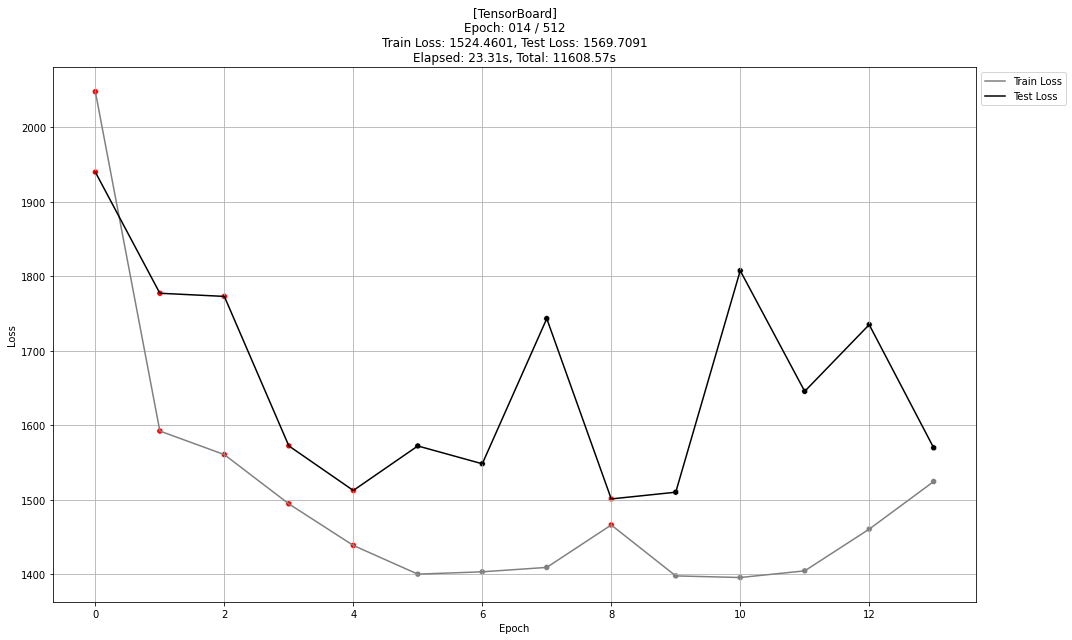

trainset:   3%|▎         | 73/2205 [00:00<00:19, 110.23it/s]


KeyboardInterrupt: 

In [144]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-7, verbose=True)
scheduler = None
# es = EarlyStopping(patience=30,verbose=False,path='./mc/es.pt')
es = None

best_model = train(
    model,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    metric_period=1,
    target_logscale=False,
    early_stopping=es,
    plot=True,
)

In [145]:
best_model = model
best_model.load_state_dict(torch.load('./mc/best_model.pt'))

<All keys matched successfully>

In [150]:
tr_true, tr_pred = predict(best_model,train_loader,device)
va_true, va_pred = predict(best_model,valid_loader,device)

100%|██████████| 946/946 [00:03<00:00, 252.56it/s]


In [151]:
len(tr_true), len(tr_pred), len(va_true), len(va_pred)

(141100, 141100, 60500, 60500)

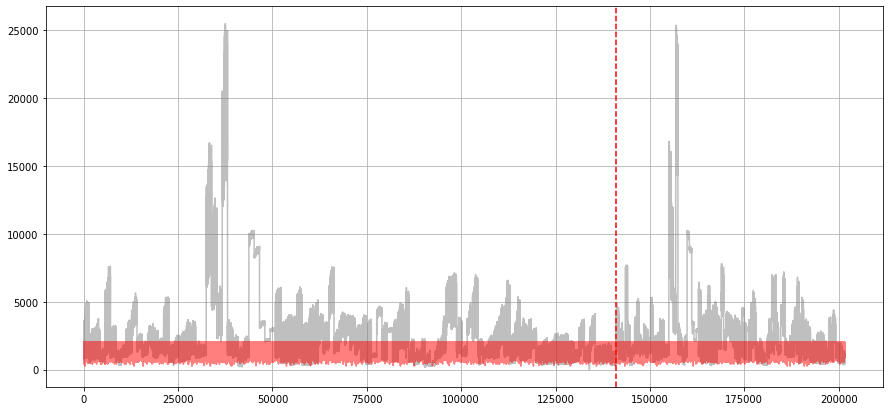

In [152]:
true = tr_true + va_true
pred = tr_pred + va_pred

plt.figure(figsize=(15,7))
sns.lineplot(x=range(len(true)),y=true,color='gray',alpha=0.5)
sns.lineplot(x=range(len(pred)),y=pred,color='red',alpha=0.5)
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.grid()
plt.show()

In [ ]:
# del TimeSeriesDataset

In [ ]:
# class TimeSeriesDataset(Dataset):
#     def __init__(self, df, window_size):
#         self.df = df
#         self.window_size = window_size

#     def __len__(self):
#         return len(self.df) - self.window_size

#     def __getitem__(self, idx):
#         x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
#         if self.df.shape[1] > 1:
#             y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
#         else:
#             y = None
#         return x, y

# def create_data_loader(df, window_size, batch_size):
#     dataset = TimeSeriesDataset(df, window_size)
#     data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#     return data_loader

In [ ]:
# train_loader = create_data_loader(pd.concat([X_oh,y],axis=1).values, window_size=24, batch_size=16)

In [ ]:
# input_size = X_oh.shape[1]
input_size = 21
hidden_size = 128
num_layers = 1
output_size = 1
learning_rate = 0.9
num_epochs = 256
learning_rate = 0.3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM(input_size, hidden_size, num_layers, output_size)#.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    tr_loss_list = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tr_loss_list.append(loss.item())
        
    progress = 'Epoch [{}/{}], loss: {:.4f}' \
        .format(str(epoch+1).zfill(len(str(num_epochs))),num_epochs,np.mean(tr_loss_list))
        
#     va_loss_list = []
#     for i, (inputs, labels) in enumerate(valid_loader):
#         inputs = inputs.to(device)
#         labels = labels.unsqueeze(1).to(device)

#         # Forward
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         va_loss_list.append(loss.item())
        
#     progress = 'Epoch [{}/{}], loss: {:.4f}, val_loss: {:.4f}' \
#         .format(str(epoch+1).zfill(len(str(num_epochs))),num_epochs,np.mean(tr_loss_list),np.mean(va_loss_list))
    print (progress)

In [ ]:
tr_true, tr_pred = predict(model,train_loader,device)
va_true, va_pred = predict(model,valid_loader,device)

In [ ]:
len(tr_true), len(tr_pred), len(va_true), len(va_pred)

In [ ]:
true = tr_true + va_true
pred = tr_pred + va_pred

plt.figure(figsize=(15,7))
sns.lineplot(x=range(len(true)),y=true,color='gray',alpha=0.5)
sns.lineplot(x=range(len(pred)),y=pred,color='red',alpha=0.5)
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.grid()
plt.show()

<br></br>

# Inference

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = pred

In [ ]:
submit.head()

In [ ]:
# public : 7.5409287264 (log)
submit.to_csv('./out/8_weiens_noseg_stacking.csv',index=False)